In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
from regressors import stats

In [4]:
data = pd.read_csv('XandY.csv',index_col=[0])

In [5]:
### check data shape should be (10869, 194)
data.shape

(10869, 194)

In [6]:
########################################################
## 3. label y variables according to their GHG change
##    2 -- GHG decreases more than 10%
##    1 -- GHG decreases less than 10%
##    0 -- GHG increases
########################################################
def helper(x):
    if x < -0.40:
        return 2
    elif x < 0:
        return 1
    return 0
data.loc[:, 'GHG'] = data['GHG change'].apply(lambda x: helper(x))

In [7]:
data['GHG'].value_counts()

1    5319
0    4448
2    1102
Name: GHG, dtype: int64

In [8]:
### delete some columns
cate_col = data.iloc[:,4:180].columns.to_list()
test = data[cate_col].sum()
keep_columns = test.where(test>20).dropna().keys().to_list()

In [9]:
drop_columns = test.where(test<20).dropna().keys().to_list()

In [10]:
data = data.drop(drop_columns,axis=1)

In [11]:
data.shape

(10869, 89)

In [12]:
## x columns
x_col = data.iloc[:,2:-1].columns.to_list()

In [13]:
data.head(3)

,bbl,GHG change,Year Built,ENERGY STAR Score,Largest Property Use Type_College/University,Largest Property Use Type_Distribution Center,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Manufacturing/Industrial Plant,Largest Property Use Type_Medical Office,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Office,Largest Property Use Type_Other,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Parking,Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,bldgclass_C1,bldgclass_C6,bldgclass_C7,bldgclass_C9,bldgclass_D0,bldgclass_D1,bldgclass_D3,bldgclass_D4,bldgclass_D5,bldgclass_D6,bldgclass_D7,bldgclass_D8,bldgclass_D9,bldgclass_E1,bldgclass_E7,bldgclass_E9,bldgclass_F1,bldgclass_F5,bldgclass_G1,bldgclass_H1,bldgclass_H2,bldgclass_H3,bldgclass_H8,bldgclass_I1,bldgclass_I6,bldgclass_I7,bldgclass_I9,bldgclass_K4,bldgclass_K6,bldgclass_K8,bldgclass_N2,bldgclass_O2,bldgclass_O3,bldgclass_O4,bldgclass_O5,bldgclass_O6,bldgclass_O9,bldgclass_R2,bldgclass_R4,bldgclass_RB,bldgclass_RC,bldgclass_RD,bldgclass_RM,bldgclass_W2,bldgclass_W6,bldgclass_W9,landuse_10.0,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_8.0,Self-Reported Gross Floor Area (ft²),Occupancy,bldgarea,numfloors,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,assessland,assesstot,builtfar,GHG
0,3087210375,-0.140623,1959,87,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.021340,1.0,0.021477,0.156863,0.000000,0.101654,0.000000,0.000000,0.0,0.0,0.0,0.002989,0.011194,0.072727,1
1,3008640001,-0.110197,1931,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.003770,1.0,0.026300,0.029412,0.246165,0.000000,0.324291,0.000000,0.0,0.0,0.0,0.006235,0.021549,0.028458,1
2,1013110040,-0.109324,1977,50,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.023691,1.0,0.023312,0.313725,0.246165,0.000000,0.318723,0.017171,0.0,0.0,0.0,0.047046,0.059030,0.290232,1


### Exploration 

#### Largest Property Use Type 

In [263]:
### merge building types <30 to others

In [423]:
X.loc[X['Largest Property Use Type'].str.contains("Other"), 'Largest Property Use Type'] = "Other"

NameError: name 'X' is not defined

In [265]:
building_type = X['Largest Property Use Type'].value_counts().to_frame()

In [266]:
type_list = building_type[building_type['Largest Property Use Type']<30].index.to_list()

In [267]:
dct = {}
for _ in type_list:
    dct[_] = 'Other'

In [268]:
X.loc[:, 'Largest Property Use Type'] = X['Largest Property Use Type'].apply(lambda x: dct.get(x, x))

In [269]:
X['Largest Property Use Type'].value_counts()

Multifamily Housing                      8502
Office                                   1162
Other                                     325
Hotel                                     158
Residence Hall/Dormitory                   99
College/University                         93
Non-Refrigerated Warehouse                 92
Senior Care Community                      91
Retail Store                               76
Self-Storage Facility                      68
K-12 School                                64
Distribution Center                        38
Hospital (General Medical & Surgical)      34
Manufacturing/Industrial Plant             34
Parking                                    32
Name: Largest Property Use Type, dtype: int64

In [271]:
merge = X.merge(Y,left_index=True, right_index=True)

In [272]:
merge.head(3)

,Largest Property Use Type,Year Built,ENERGY STAR Score,bldgclass,landuse,Self-Reported Gross Floor Area (ft²),Occupancy,bldgarea,numfloors,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,assessland,assesstot,builtfar,GHG Change
1,Other,"1,931",1,M1,8.0,0.003770,1.0,0.026300,0.029412,0.246165,0.0,0.324291,0.000000,0.0,0.0,0.000000,0.006235,0.021549,0.028458,1
2,Office,"1,977",50,O4,5.0,0.023691,1.0,0.023312,0.313725,0.246165,0.0,0.318723,0.017171,0.0,0.0,0.000000,0.047046,0.059030,0.290232,1
3,Manufacturing/Industrial Plant,"1,994",Not Available,F2,6.0,0.040819,1.0,0.033010,0.029412,0.246165,0.0,0.136856,0.000000,0.0,0.0,0.577983,0.055598,0.029931,0.004065,2


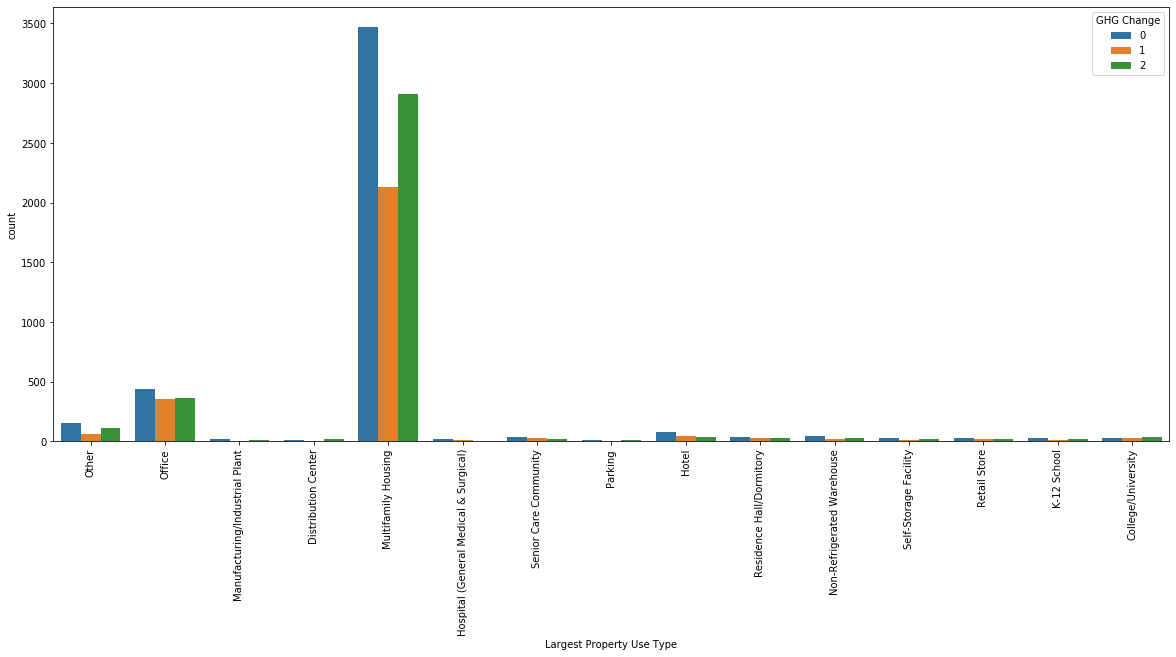

In [273]:
plt.figure(figsize=(20, 8))
sns.countplot(merge['Largest Property Use Type'], hue='GHG Change', data=merge)
plt.xticks(rotation=90)
plt.show()

<Figure size 1440x576 with 0 Axes>

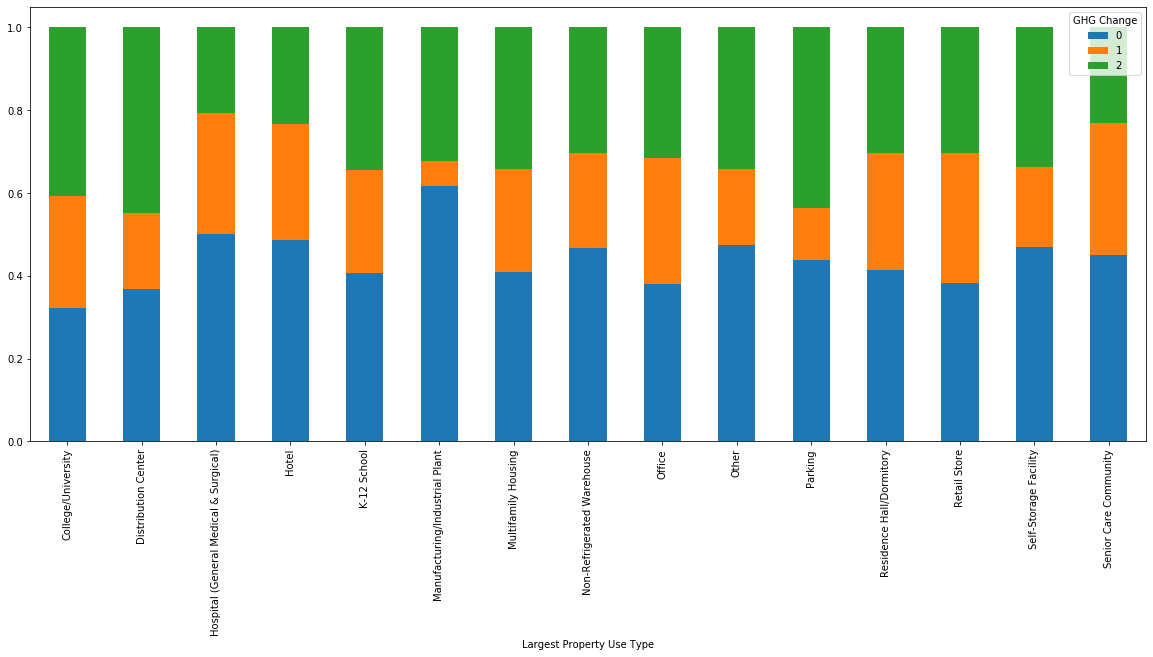

In [274]:
plt.figure(figsize=(20, 8))
props = merge.groupby("Largest Property Use Type")['GHG Change'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', figsize=(20, 8))

## run models

### try PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=2).fit(data[x_col])
print("Total variance of the data (original 30D :", np.sum(np.var(data[x_col],axis=0)))
print("Variance explained via the first and second components:\n" , pca.explained_variance_)
print("Variance explained via the first and second components (ratio):\n", pca.explained_variance_ratio_)

Total variance of the data (original 30D : 1574.7198543802663
Variance explained via the first and second components:
 [916.48036218 656.40898856]
Variance explained via the first and second components (ratio):
 [0.58194227 0.4168034 ]


In [16]:
X_pca = pca.transform(data[x_col]) 
print("Original shape: {}".format(str(data[x_col].shape))) 
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (10869, 86)
Reduced shape: (10869, 2)


### 0) Split train and test datasets

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
### original datasets 

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data[x_col], data[['GHG','bbl']], test_size=0.3)

In [20]:
x_train.shape

(7608, 86)

In [21]:
x_test.shape

(3261, 86)

In [22]:
y_train.shape

(7608, 2)

In [23]:
### pca datasets

In [24]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, data[['GHG','bbl']], test_size=0.2)

In [25]:
x_train_pca.shape

(8695, 2)

### 1) Naive Bayes

In [541]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from mixed_naive_bayes import MixedNB


In [542]:
x_train.shape

(7608, 86)

In [543]:
x_train.head(3)

,Year Built,ENERGY STAR Score,Largest Property Use Type_College/University,Largest Property Use Type_Distribution Center,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Manufacturing/Industrial Plant,Largest Property Use Type_Medical Office,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Office,Largest Property Use Type_Other,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Parking,Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,bldgclass_C1,bldgclass_C6,bldgclass_C7,bldgclass_C9,bldgclass_D0,bldgclass_D1,bldgclass_D3,bldgclass_D4,bldgclass_D5,bldgclass_D6,bldgclass_D7,bldgclass_D8,bldgclass_D9,bldgclass_E1,bldgclass_E7,bldgclass_E9,bldgclass_F1,bldgclass_F5,bldgclass_G1,bldgclass_H1,bldgclass_H2,bldgclass_H3,bldgclass_H8,bldgclass_I1,bldgclass_I6,bldgclass_I7,bldgclass_I9,bldgclass_K4,bldgclass_K6,bldgclass_K8,bldgclass_N2,bldgclass_O2,bldgclass_O3,bldgclass_O4,bldgclass_O5,bldgclass_O6,bldgclass_O9,bldgclass_R2,bldgclass_R4,bldgclass_RB,bldgclass_RC,bldgclass_RD,bldgclass_RM,bldgclass_W2,bldgclass_W6,bldgclass_W9,landuse_10.0,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_8.0,Self-Reported Gross Floor Area (ft²),Occupancy,bldgarea,numfloors,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,assessland,assesstot,builtfar
3715,1966,54,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.032631,1.0,0.029818,0.343137,0.079881,0.068667,0.080949,0.049924,0.024962,0.0,0.0,0.027177,0.054888,0.110107
9290,1958,52,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.011175,1.0,0.011348,0.058824,0.000000,0.101654,0.000000,0.000000,0.000000,0.0,0.0,0.001756,0.005108,0.038622
13679,1927,66,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.010359,1.0,0.010532,0.161765,0.008699,0.098062,0.011459,0.000000,0.000000,0.0,0.0,0.024676,0.026087,0.138566


#### use original datasets to fit the model

In [544]:
len(keep_columns)

69

In [561]:
categ_data = [*range(2,len(keep_columns)+2)]

In [562]:
nb_y_train= y_train['GHG']

In [563]:
MNB = MixedNB(categorical_features=categ_data)

In [564]:
mnb_pred = MNB.fit(x_train, nb_y_train)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [565]:
len(mnb_pred.predict(x_test))

3261

In [566]:
len(y_pred)

2174

In [567]:
y_pred = mnb_pred.predict(x_test)

print("Number of mislabeled points out of a total %d points : %d" 
      % (x_test.shape[0], (y_test['GHG'] != y_pred).sum()))

Number of mislabeled points out of a total 3261 points : 1722


In [568]:
print ("Accuracy: ", MNB.score(x_train,nb_y_train))

Accuracy:  0.47082018927444796


#### use PCA datasets to fit the model

In [569]:
## pca
nb_y_train_pca= y_train_pca['GHG']
gnb = GaussianNB()
y_pred = gnb.fit(x_train_pca, nb_y_train_pca).predict(x_test_pca)
print("Number of mislabeled points out of a total %d points : %d" 
      % (x_test_pca.shape[0], (y_test_pca['GHG'] != y_pred).sum()))

Number of mislabeled points out of a total 2174 points : 1028


In [570]:
print ("Accuracy: ", gnb.score(x_train_pca,nb_y_train_pca))

Accuracy:  0.5334100057504313


comments:
    * PCA performs better in naive bayes model

### 2) Logistic Regression

In [571]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix # for confusion matrix
import sklearn.metrics as metrics # for ROC curve

#### use original datasets to fit the model

In [572]:
model = LogisticRegression(multi_class='multinomial',solver='newton-cg').fit(x_train, y_train['GHG'])

In [573]:
print ("Accuracy:",round(model.score(x_train, y_train['GHG']),3))

Accuracy: 0.559


In [574]:
parameters = model.coef_
odds_ratio = np.exp(parameters)

In [575]:
para_results = pd.DataFrame()
para_results['feature'] = x_train.columns.tolist()
para_results['odds_ratio'] = odds_ratio[0]
para_results.sort_values(by='odds_ratio',ascending=False).head(20)

,feature,odds_ratio
72,Self-Reported Gross Floor Area (ft²),2.689646
63,bldgclass_W6,2.536383
62,bldgclass_W2,2.180251
64,bldgclass_W9,2.050139
8,Largest Property Use Type_Medical Office,1.879182
85,builtfar,1.759217
7,Largest Property Use Type_Manufacturing/Indust...,1.703894
30,bldgclass_D8,1.602725
13,Largest Property Use Type_Other - Entertainmen...,1.595048
44,bldgclass_I7,1.582634


In [576]:
# First, predicted y based on the train dataset is computed
print("-------Probability-------")
y_prob = model.predict_proba(x_train)
y_pred_train = model.predict(x_train)
print (y_prob[:10])
print("-----Predicted Y-----")
print (y_pred_train.tolist()[:10])
print("-----Actual Y-----")
print (y_train['GHG'].tolist()[:10])

# Confusion matrix
# [[TN, FP]
#  [FN, TP]]
confusion = confusion_matrix(y_train['GHG'],y_pred_train)
print ("------Confusion Matrix is ---------")
print (confusion)

-------Probability-------
[[0.32334784 0.56735359 0.10929857]
 [0.44172307 0.51048357 0.04779336]
 [0.34545993 0.54698868 0.10755139]
 [0.35335578 0.57168847 0.07495574]
 [0.4624043  0.38242348 0.15517221]
 [0.48738811 0.4503872  0.06222469]
 [0.32103208 0.55491376 0.12405416]
 [0.05860692 0.28697239 0.65442069]
 [0.12718308 0.43839214 0.43442478]
 [0.4702866  0.52100473 0.00870867]]
-----Predicted Y-----
[1, 1, 1, 1, 0, 0, 1, 2, 1, 1]
-----Actual Y-----
[0, 0, 0, 1, 1, 1, 1, 1, 2, 1]
------Confusion Matrix is ---------
[[1459 1623   36]
 [ 941 2727   25]
 [ 124  604   69]]


In [577]:
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]

Accuracy = (TN + TP) / (TN + FP + FN + TP)
Recall = (TP) / (TP + FN)
Precision = (TP) / (TP+FP)
Specificity = (TN) / (TN+FP)

print ("Accuracy:",Accuracy)
print ("Recall:",Recall)
print ("Precision:",Precision)
print ("Specificity:",Specificity)

Accuracy: 0.6201481481481481
Recall: 0.7434569247546347
Precision: 0.6268965517241379
Specificity: 0.4733939000648929


In [578]:
y_pred_test = model.predict(x_test)

# Confusion matrix
# [[TN, FP]
#  [FN, TP]]
confusion = confusion_matrix(y_test['GHG'],y_pred_test)

print (confusion)

TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]

Accuracy = (TN + TP) / (TN + FP + FN + TP)
Recall = (TP) / (TP + FN)
Precision = (TP) / (TP+FP)
Specificity = (TN) / (TN+FP)

print ("Accuracy:",round(Accuracy,3))
print ("Recall:",round(Recall,3))
print ("Precision:",round(Precision,3))
print ("Specificity:",round(Specificity,3))

[[ 567  747   16]
 [ 433 1180   13]
 [  42  236   27]]
Accuracy: 0.597
Recall: 0.732
Precision: 0.612
Specificity: 0.432


#### use pca datasets to fit the model

In [579]:
### pca
model = LogisticRegression(multi_class='multinomial',solver='newton-cg').fit(x_train_pca, y_train_pca['GHG'])
print ("Accuracy:",round(model.score(x_train_pca, y_train_pca['GHG']),3))

Accuracy: 0.525


In [580]:
# First, predicted y based on the train dataset is computed
print("-------Probability-------")
y_prob = model.predict_proba(x_train_pca)
y_pred_train = model.predict(x_train_pca)
print (y_prob[:10])
print("-----Predicted Y-----")
print (y_pred_train.tolist()[:10])
print("-----Actual Y-----")
print (y_train_pca['GHG'].tolist()[:10])

# Confusion matrix
# [[TN, FP]
#  [FN, TP]]
confusion = confusion_matrix(y_train_pca['GHG'],y_pred_train)
print ("------Confusion Matrix is ---------")
print (confusion)

-------Probability-------
[[0.6390701  0.34952798 0.01140192]
 [0.46109753 0.50521765 0.03368482]
 [0.31596861 0.53020104 0.15383035]
 [0.57889659 0.41045486 0.01064855]
 [0.30026384 0.51192782 0.18780834]
 [0.42061489 0.51200167 0.06738344]
 [0.40040954 0.52952917 0.07006129]
 [0.43590703 0.47061539 0.09347758]
 [0.43303348 0.49716376 0.06980275]
 [0.56207099 0.42063807 0.01729095]]
-----Predicted Y-----
[0, 1, 1, 0, 1, 1, 1, 1, 1, 0]
-----Actual Y-----
[0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
------Confusion Matrix is ---------
[[1321 2249    0]
 [ 998 3246    0]
 [  94  787    0]]


In [581]:
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]

Accuracy = (TN + TP) / (TN + FP + FN + TP)
Recall = (TP) / (TP + FN)
Precision = (TP) / (TP+FP)
Specificity = (TN) / (TN+FP)

print ("Accuracy:",Accuracy)
print ("Recall:",Recall)
print ("Precision:",Precision)
print ("Specificity:",Specificity)

Accuracy: 0.5844637829536729
Recall: 0.7648444863336475
Precision: 0.5907188353048226
Specificity: 0.3700280112044818


comments:
    * pca performs poorly in the logistic datasets

## decision tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [120]:
x_ = []
train_ = []
test_ = []
for i in range(1, x_train.shape[1]):
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(x_train, y_train['GHG'])
    train_.append(clf.score(x_train, y_train['GHG']))
    test_.append(clf.score(x_test, y_test['GHG']))
    x_.append(i)

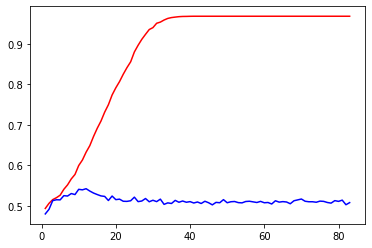

In [121]:
plt.plot(x_, train_, 'r')
plt.plot(x_, test_, 'b')
plt.show()

In [122]:
test_.index(max(test_))

11

In [27]:
# Build a model
clf = DecisionTreeClassifier(max_depth=11)

# Fit to your train data (training process)
final = clf.fit(x_train, y_train['GHG'])

# Train/test score
print (clf.score(x_train, y_train['GHG']))
print (clf.score(x_test, y_test['GHG']))

0.6590431125131441
0.5795768169273229


In [124]:
print ("Feature importances: ")
print (clf.feature_importances_)
print (x_train.columns)

Feature importances: 
[1.52396503e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.68372051e-03 0.00000000e+00 3.20652270e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.83173754e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.32704663e-03
 1.85218170e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.22200704e-03 0.00000000e+00
 1.09512184e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.27683556e-03 1.70244742e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.32307957e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.23888133e-03
 0.00000000e+00 0.00000000e+00 1.76951353e-03 0.00000000e+00
 0

In [28]:
dtc_imp = pd.DataFrame(list(zip(x_train.columns, clf.feature_importances_)), columns=['name', 'importance']).sort_values(by='importance', ascending=False)[:16].reset_index(drop=True)

In [589]:
dtc_imp

,name,importance
0,ENERGY STAR Score,0.281140
1,Self-Reported Gross Floor Area (ft²),0.168396
2,Year Built,0.093193
3,builtfar,0.067729
4,assesstot,0.059818
5,bldgarea,0.057915
6,assessland,0.046962
7,numfloors,0.041268
8,retailarea,0.033213
9,garagearea,0.021261


[Text(1514.3684605966164, 5209.5, 'X[72] <= 0.001\nentropy = 0.791\nsamples = 7608\nvalue = [[3141, 3697, 770 ... 0, 0, 0]\n[1, 1, 1 ... 1, 2, 1]]'),
 Text(272.0436331255566, 4756.5, 'X[9] <= 0.5\nentropy = 0.118\nsamples = 175\nvalue = [[1, 160, 14 ... 0, 0, 0]\n[0, 0, 0 ... 0, 0, 0]]'),
 Text(232.29296527159397, 4303.5, 'X[85] <= 0.072\nentropy = 0.531\nsamples = 7\nvalue = [[1, 1, 5 ... 0, 0, 0]\n[0, 0, 0 ... 0, 0, 0]]'),
 Text(212.41763134461266, 3850.5, 'X[84] <= 0.03\nentropy = 0.389\nsamples = 6\nvalue = [[0, 1, 5 ... 0, 0, 0]\n[0, 0, 0 ... 0, 0, 0]]'),
 Text(192.54229741763137, 3397.5, 'X[72] <= 0.0\nentropy = 0.25\nsamples = 2\nvalue = [[0, 0, 2 ... 0, 0, 0]\n[0, 0, 0 ... 0, 0, 0]]'),
 Text(172.66696349065006, 2944.5, 'entropy = 0.0\nsamples = 1\nvalue = [[0, 0, 1 ... 0, 0, 0]\n[0, 0, 0 ... 0, 0, 0]]'),
 Text(212.41763134461266, 2944.5, 'entropy = 0.0\nsamples = 1\nvalue = [[0, 0, 1 ... 0, 0, 0]\n[0, 0, 0 ... 0, 0, 0]]'),
 Text(232.29296527159397, 3397.5, 'entropy = 0.188\nsam

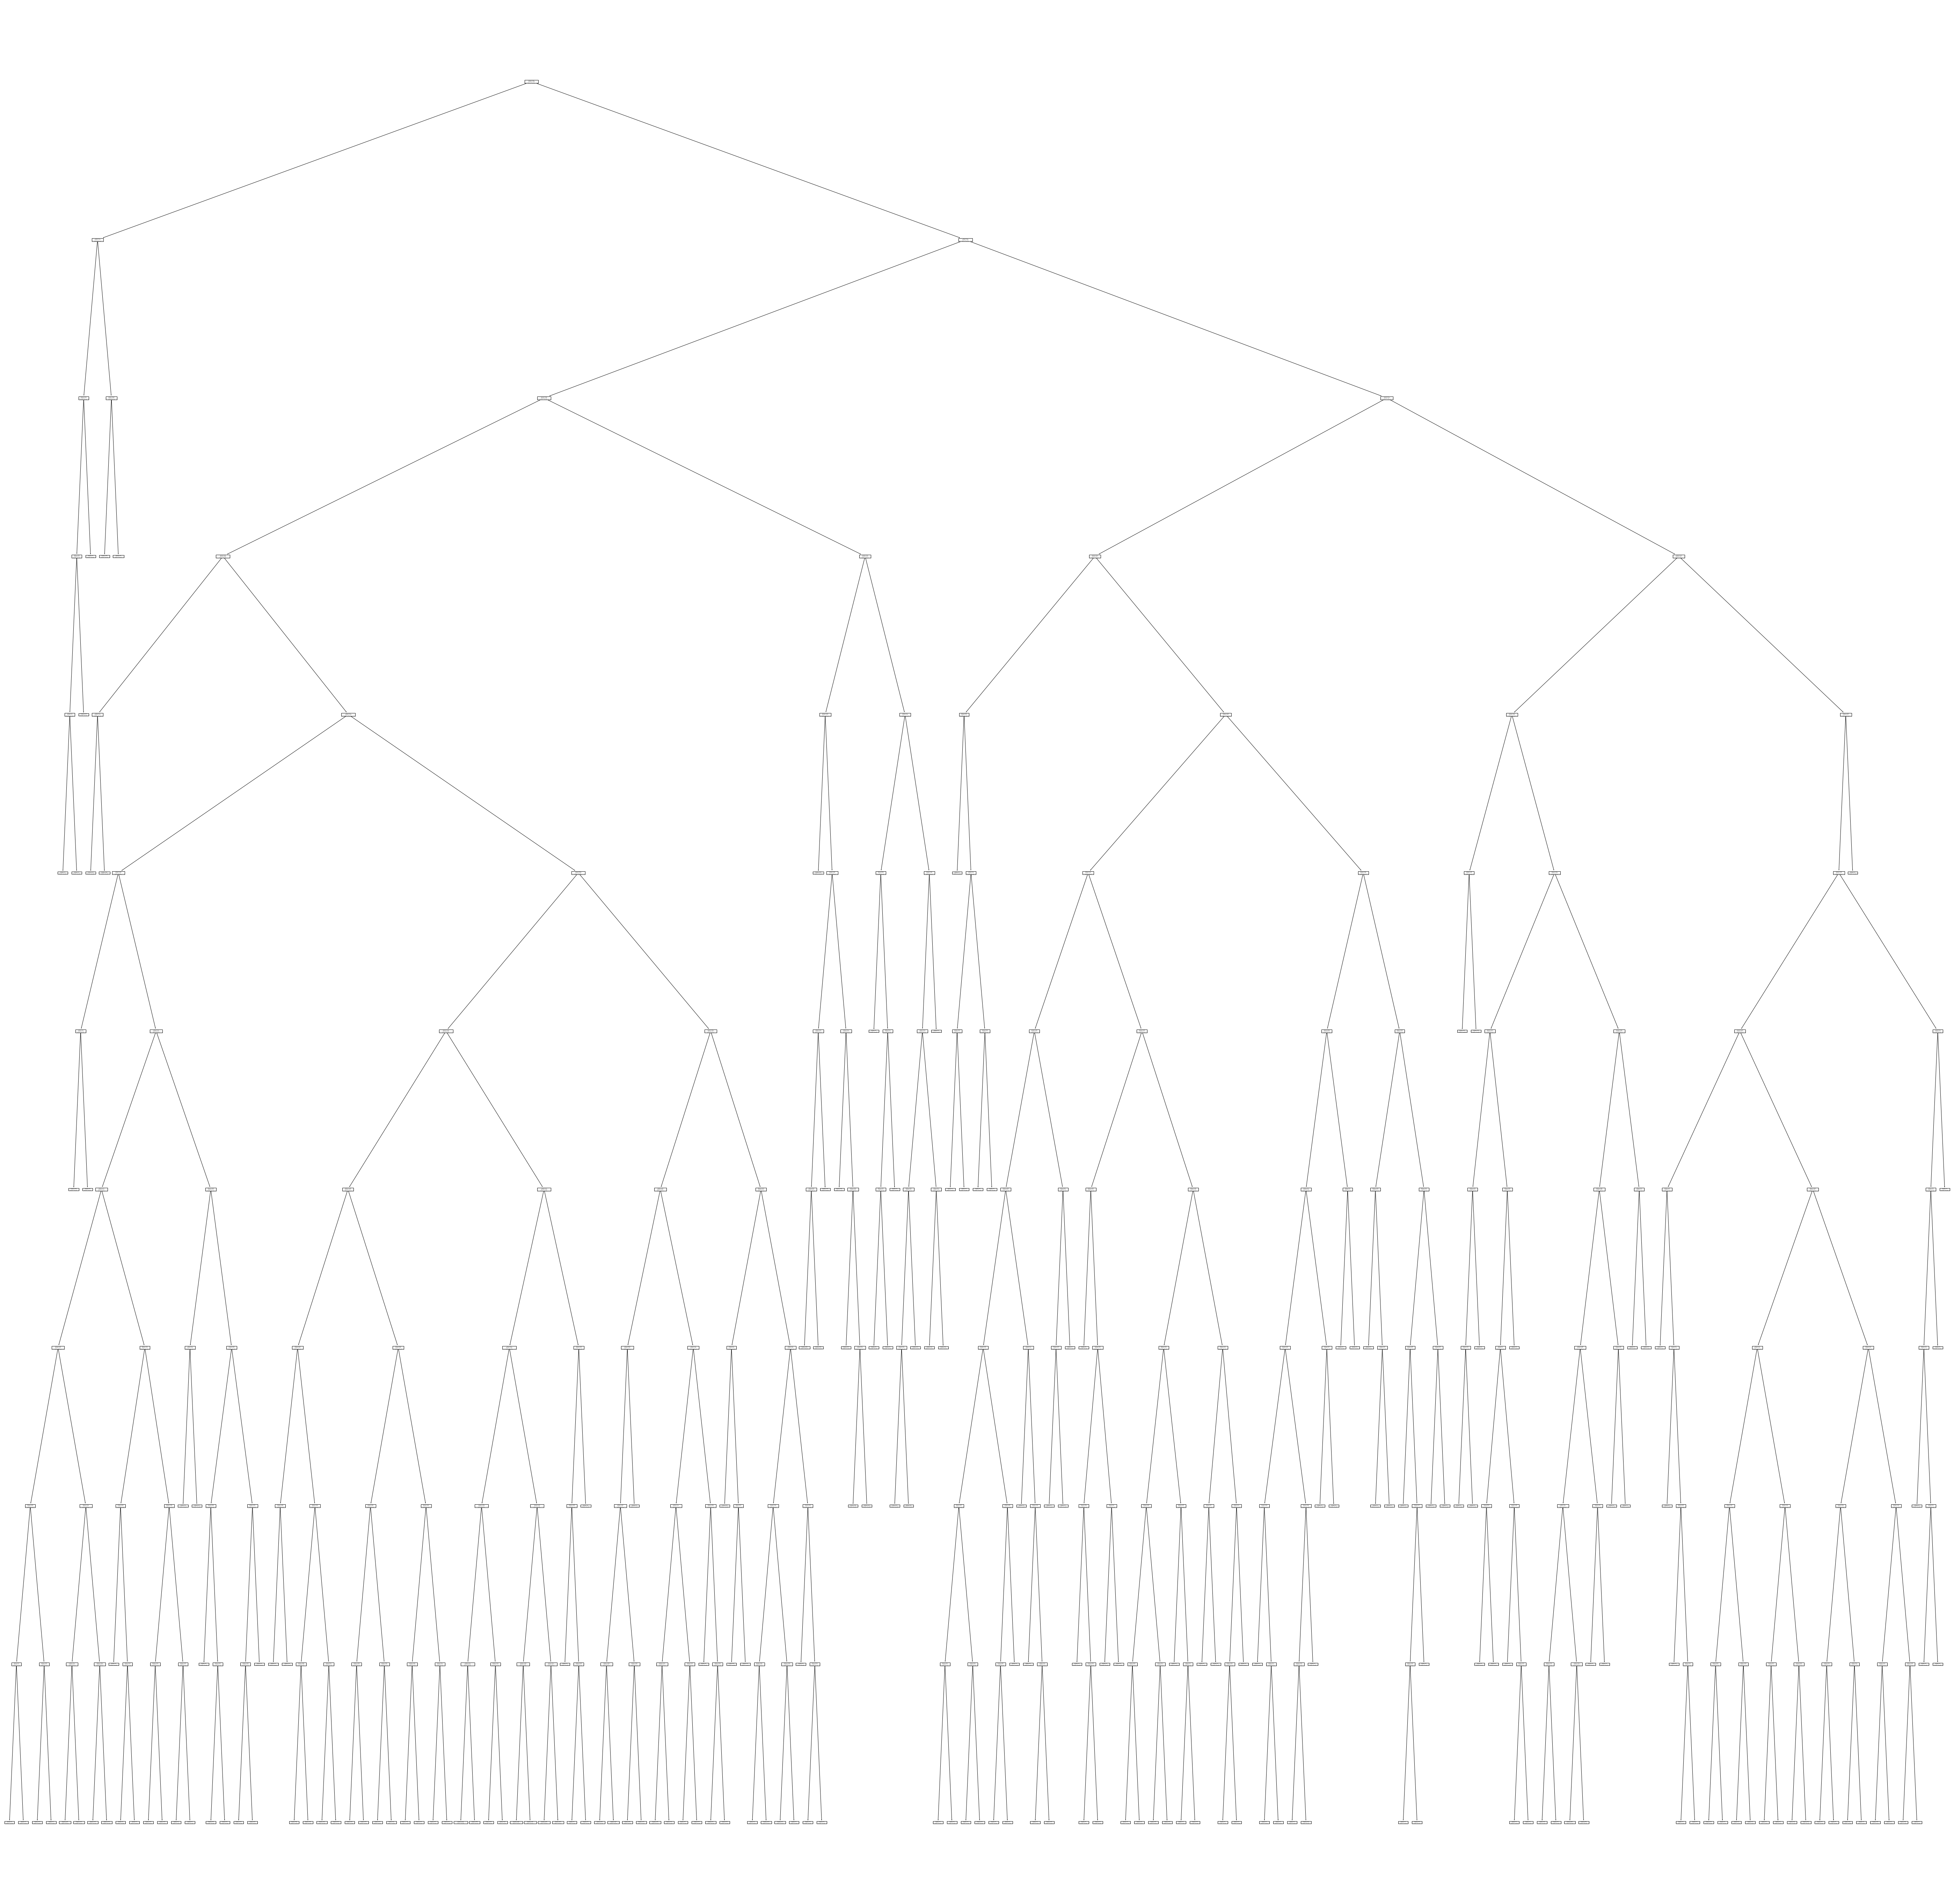

In [29]:
from sklearn import tree
plt.figure(figsize=(100,100))
tree.plot_tree(clf.fit(x_train, y_train)) 

In [29]:
from sklearn.tree import export_graphviz

In [30]:
import pydotplus

In [31]:
dot_Data = export_graphviz(final,out_file=None)

graph = pydotplus.graph_from_dot_data(dot_Data)

graph.write_pdf("tree.pdf")

True

In [47]:
x_train.columns

Index(['Year Built', 'ENERGY STAR Score',
       'Largest Property Use Type_College/University',
       'Largest Property Use Type_Distribution Center',
       'Largest Property Use Type_Hospital (General Medical & Surgical)',
       'Largest Property Use Type_Hotel',
       'Largest Property Use Type_K-12 School',
       'Largest Property Use Type_Manufacturing/Industrial Plant',
       'Largest Property Use Type_Medical Office',
       'Largest Property Use Type_Multifamily Housing',
       'Largest Property Use Type_Non-Refrigerated Warehouse',
       'Largest Property Use Type_Office', 'Largest Property Use Type_Other',
       'Largest Property Use Type_Other - Entertainment/Public Assembly',
       'Largest Property Use Type_Parking',
       'Largest Property Use Type_Residence Hall/Dormitory',
       'Largest Property Use Type_Retail Store',
       'Largest Property Use Type_Self-Storage Facility',
       'Largest Property Use Type_Senior Care Community', 'bldgclass_C1',
       '

In [54]:
x_train.columns[72]

'Self-Reported Gross Floor Area (ft²)'

In [51]:
x_train['assesstot'].describe()

count    7608.000000
mean        0.025325
std         0.060111
min         0.000000
25%         0.003417
50%         0.008837
75%         0.020825
max         1.000000
Name: assesstot, dtype: float64

Text(0, 0.5, 'Feature')

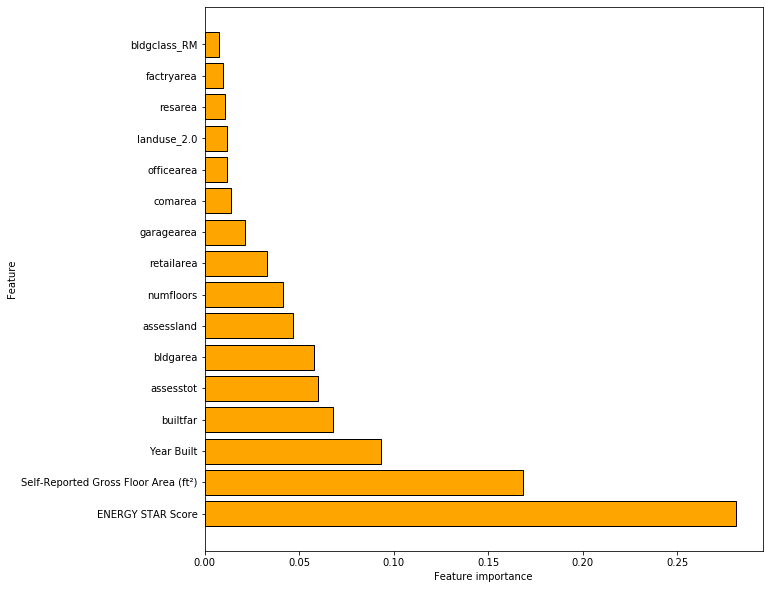

In [590]:
n_features = dtc_imp.shape[0]
plt.figure(figsize=(10,10))
plt.barh(range(n_features), dtc_imp['importance'], align='center', color='orange', edgecolor='k')
plt.yticks(np.arange(n_features), dtc_imp['name'])
plt.xlabel("Feature importance")
plt.ylabel("Feature")

## random forest

In [591]:
from sklearn.ensemble import RandomForestClassifier

In [592]:
x_ = []
train_ = []
test_ = []
for i in range(1, 200,10):
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(x_train, y_train['GHG'])
    train_.append(clf.score(x_train, y_train['GHG']))
    test_.append(clf.score(x_test, y_test['GHG']))
    x_.append(i)

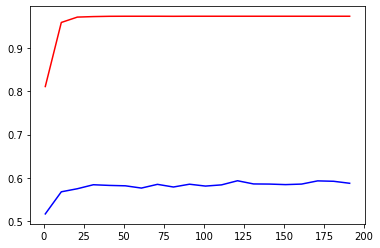

In [593]:
plt.plot(x_, train_, 'r')
plt.plot(x_, test_, 'b')
plt.show()

In [594]:
test_.index(max(test_))

12

In [595]:
clf = RandomForestClassifier(n_estimators=135)
clf.fit(x_train, y_train['GHG'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=135,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [596]:
print (clf.score(x_train, y_train['GHG']))
print (clf.score(x_test, y_test['GHG']))

0.972397476340694
0.5841766329346826


In [597]:
print ("Feature importances: ")
print (clf.feature_importances_)
print (x_train.columns)

Feature importances: 
[0.09004835 0.14001958 0.00121719 0.00057472 0.00040514 0.00102827
 0.00132728 0.00106399 0.00037555 0.00355509 0.00073603 0.00292498
 0.00086434 0.0003244  0.00048796 0.00126554 0.00083268 0.00046096
 0.00079409 0.0012258  0.00141297 0.00107582 0.00265036 0.00072656
 0.00411785 0.00314656 0.00568604 0.0011372  0.00257604 0.00299945
 0.00100011 0.00206279 0.00096817 0.00043011 0.00039881 0.00042254
 0.00034202 0.00019717 0.00044461 0.00046758 0.00061821 0.00031638
 0.00054897 0.00074009 0.00050179 0.00038945 0.0003537  0.00047664
 0.00015067 0.00083184 0.00045765 0.00081926 0.00152418 0.00073466
 0.00150035 0.00026575 0.00062594 0.0023621  0.00063126 0.00070022
 0.00036244 0.00327389 0.00035958 0.00068685 0.00037791 0.00027455
 0.00256711 0.00417403 0.0039804  0.0024965  0.00109315 0.00191614
 0.10765238 0.01108355 0.08895179 0.04696773 0.03286792 0.03428542
 0.02597064 0.03035061 0.01605622 0.01059556 0.00359437 0.0899139
 0.09016891 0.09363466]
Index(['Year Buil

In [598]:
rfc_imp = pd.DataFrame(list(zip(x_train.columns, clf.feature_importances_)), columns=['name', 'importance']).sort_values(by='importance', ascending=False)[:16].reset_index(drop=True)

Text(0, 0.5, 'Feature')

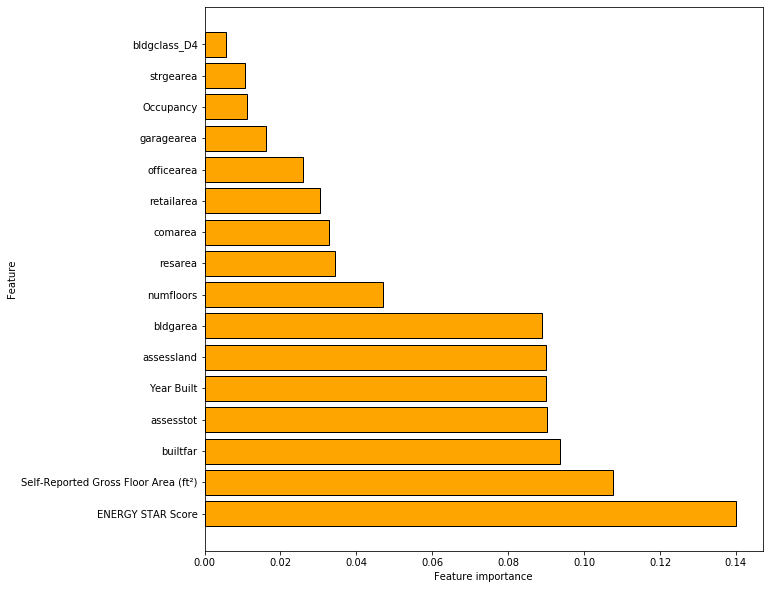

In [599]:
n_features = rfc_imp.shape[0]
plt.figure(figsize=(10,10))
plt.barh(range(n_features), rfc_imp['importance'], align='center', color='orange', edgecolor='k')
plt.yticks(np.arange(n_features), rfc_imp['name'])
plt.xlabel("Feature importance")
plt.ylabel("Feature")

## Support Vector Machines (SVMs)

In [600]:
from sklearn import svm

In [601]:
clf = svm.SVC(kernel='rbf', gamma=1) 
clf.fit(x_train, y_train['GHG'])
clf.score(x_train, y_train['GHG'])

0.9022082018927445

In [602]:
##clf.fit(x_train, y_train['GHG'])
clf.score(x_test, y_test['GHG'])

0.5314320760502913

In [603]:
## use pca 
clf = svm.SVC(kernel='rbf', gamma=1) 
clf.fit(x_train_pca, y_train_pca['GHG'])
clf.score(x_train_pca, y_train_pca['GHG'])

0.7607820586543991

In [604]:
clf.score(x_test_pca, y_test_pca['GHG'])

0.5280588776448942